In [1]:
# This file is modified version of original:
# https://www.kaggle.com/code/javigallego/rsna-complete-eda-external-data/notebook

---
## 1 | Introduction
---

## Goal of the Competition

The goal of this competition is to identify cases of breast cancer in mammograms from screening exams. It is important to identify cases of cancer for obvious reasons, but false positives also have downsides for patients. As millions of women get mammograms each year, a useful machine learning tool could help a great many people.

## The competition metric

It is always a good idea to understand exactly the type of predictions our model will be required to deliver.

The metric that the organizers opted for here is the probabilistic F1 score:

$pF_1 = 2\frac{pPrecision \cdot pRecall}{pPrecision+pRecall}$

with:

$pPrecision = \frac{ctp}{ctp+cfp}$

$pRecall = \frac{ctp}{count actual labels}$

ctp = sum of predictions at indexes of true positives.

cfp = sum of predictions at indexes of false positives.

Our model should output the likelihood of cancer in the corresponding image.

So what are the labels we will train on?

## Images file format

> Images are given in dicom format. Here you'll find a tutorial to get started -> [Pulmonary Dicom Preprocessing](https://www.kaggle.com/code/allunia/pulmonary-dicom-preprocessing)

DICOM or digital imaging and communications in medicine are image files sourced from different modalities and it is the international standard to transmit, store, retrieve, print, process, and display medical imaging information. However, DICOM groups information into the data set, and that means that the image file contains the patient information ID, date of birth, age, sex, and other information about the diagnosis all this within the image, as shown in the figure the main components of the medical image.

![](https://miro.medium.com/max/1400/1*BvVR-348gg0qRmVmm8gtxw.webp)

* **Pixel Depth**: is the number of bits used to encode the information of each pixel. For example, an 8-bit raster can have 256 unique values that range from 0 to 255.

* **Photometric Interpretation**: specifies how the pixel data should be interpreted for the correct image display as a monochrome or color image. To specify if the color information is or is not stored in the image pixel values, we introduce the concept of samples per pixel, also known as (number of channels).

* **Metadata**: is the information that describes the image (i.e. patients ID, date of the image).

* **Pixel Data**: is the section where the numerical values of the pixels are stored. All the components are essential but in our scope the pixel depth and pixel data. To my knowledge that ultrasound images are not an issue with converting the image to another format, but we have to look into consideration the depth of the image since we cannot convert 16-bit DICOM image to JPEG or PNG with 8-bit that might corrupt the image quality and image features. Pixel data the data that we are going to feed it to the network.

In [2]:
!pip3 install -q -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm

Custom Colors Palette: 


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


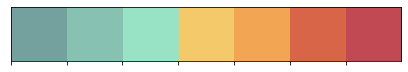

In [3]:
from IPython.display import clear_output, display_html
import os
import warnings
from pathlib import Path

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Set Color Palettes for the notebook
'''Inspired by: https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore'''
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
print('Custom Colors Palette: ')
sns.palplot(sns.color_palette(custom_colors))

import scipy as sc
from scipy import stats

# Train Test Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

---
## 2 | Exploratory Data Analysis
---

In this subsection we'll focus on examining both the metadata and the images that we're given. Let's start by loading the metadata datasets. 

In [4]:
def load_data():
    '''Load each of the datasets we are given.'''
    
    data_dir = Path("../input/rsna-breast-cancer-detection")
    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')
    return train, test, sample_submission

from termcolor import colored
def data_info(csv, name="Train"):
    '''Prints basic information about the datasets we are given.'''
    '''Inspired by: https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore'''
    
    print(colored('==== {} ===='.format(name), 'cyan', attrs=['bold']))
    print(colored('Shape: ', 'cyan', attrs=['bold']), csv.shape)
    print(colored('NaN Values: ', 'cyan', attrs=['bold']), csv.isnull().sum().sum(), '\n')
    #print(colored('Columns: ', 'blue', attrs=['bold']), list(csv.columns))
    
    display_html(csv.head())
    if name != 'Sample Submission': print("\n")

train, test, sample_submission = load_data()
clear_output()

names = ["Train", "Test", "Sample Submission"]
for i, df in enumerate([train, test, sample_submission]): 
    data_info(df, names[i])

==== Train ====
Shape:  (54706, 14)
NaN Values:  53693 



,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True




==== Test ====
Shape:  (4, 9)
NaN Values:  0 



,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R




==== Sample Submission ====
Shape:  (2, 2)
NaN Values:  0 



,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [25]:
train.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

📌 **Early insights:** 
* For the metadata of training file, we have plenty of missing values. 
* Repeated values for `patient_id`. It seems that for each patient, 4 images have been taken. 
* Some features from the training set do not appear in the testing one. 

In order to make a proper analysis, we're gonna load every metadata from the images into a dataframe. Some of this data may be useful afterwards for the model training and splitting strategies. Below, you have a quick example of .dcm file metadata. 

In [5]:
import pydicom
from os import listdir

dcm_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm"
img = pydicom.dcmread(dcm_path)
img

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

The image data is stored in `Pixel Data`. Everything else is metadata.

* The `Rows` and `Columns` values tell us the image size.
* The `Pixel Spacing` and `Slice Thickness` tell us the pixel size and thickness.
* The `Window Center` and `Window Width` give information about the brightness and contrast of the image respectively.
* The `Rescale Intercept` and `Rescale Slope` determine the range of pixel values. (ref).
* `ImagePositionPatient` tells us the x, y, and z coordinates of the top left corner of each image in mm
* `InstanceNumber` is the slice number.

In [6]:
dcms = []
for root, dirs, fnames in os.walk('/kaggle/input/rsna-breast-cancer-detection/train_images/'):
    dcms += list(os.path.join(root, f) for f in fnames if f.endswith('.dcm'))
print(f'There are {len(dcms)} images')

attrs = set()
for fname in tqdm(dcms[:5000]):
    with pydicom.dcmread(fname) as obj:
        attrs.update(obj.dir())

dcm_keys = list(attrs)
dcm_keys.remove('PixelData') # The actual array of pixels, this is not metadata
dcm_keys

There are 54706 images


100%|██████████| 5000/5000 [05:54<00:00, 14.11it/s]


['ContentDate',
 'ContentTime',
 'StudyInstanceUID',
 'SOPInstanceUID',
 'WindowWidth',
 'PartialView',
 'VOILUTFunction',
 'RescaleIntercept',
 'PhotometricInterpretation',
 'HighBit',
 'RescaleType',
 'Columns',
 'LossyImageCompression',
 'SeriesInstanceUID',
 'BodyPartThickness',
 'SamplesPerPixel',
 'ExposureControlMode',
 'PixelSpacing',
 'BitsAllocated',
 'ImageLaterality',
 'PixelPaddingValue',
 'CompressionForce',
 'InstanceNumber',
 'BitsStored',
 'PixelIntensityRelationshipSign',
 'RescaleSlope',
 'PatientID',
 'Rows',
 'WindowCenter',
 'PixelIntensityRelationship',
 'ExposureControlModeDescription',
 'PixelRepresentation']

In [7]:
meta = []
typemap = {
    pydicom.uid.UID: str,
    pydicom.multival.MultiValue: list
}
def cast(x):
    return typemap.get(type(x), lambda x: x)(x)

for i, fname in enumerate(tqdm(dcms[:5000])):
    with pydicom.dcmread(fname) as obj:
        meta.append([cast(obj.get(key, np.nan)) for key in dcm_keys])

dfmeta = pd.DataFrame(meta, columns=dcm_keys)
dfmeta.head()

100%|██████████| 5000/5000 [01:13<00:00, 67.66it/s] 


,ContentDate,ContentTime,StudyInstanceUID,SOPInstanceUID,WindowWidth,PartialView,VOILUTFunction,RescaleIntercept,PhotometricInterpretation,HighBit,...,InstanceNumber,BitsStored,PixelIntensityRelationshipSign,RescaleSlope,PatientID,Rows,WindowCenter,PixelIntensityRelationship,ExposureControlModeDescription,PixelRepresentation
0,20221118,184026.815884,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1.763186195,1500.0,NO,NaN,0.0,MONOCHROME2,11,...,763186195,12,1,1.0,10706,2776,1700.0,LOG,NaN,0
1,20221118,184027.212260,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1.937109986,1500.0,NO,NaN,0.0,MONOCHROME2,11,...,937109986,12,1,1.0,10706,2776,1712.0,LOG,NaN,0
2,20221118,184027.020738,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1.34700621,1500.0,NO,NaN,0.0,MONOCHROME2,11,...,34700621,12,1,1.0,10706,2776,1715.0,LOG,NaN,0
3,20221118,184026.935329,1.2.840.10009.1.2.3.10706,1.2.840.10009.1.2.3.10706.1.1167990339,1500.0,NO,NaN,0.0,MONOCHROME2,11,...,1167990339,12,1,1.0,10706,2776,1715.0,LOG,NaN,0
4,20221118,184304.095095,1.2.840.10009.1.2.3.21867,1.2.840.10009.1.2.3.21867.1.1291014447,"[1091.970000, 1091.970000, 1091.970000, 1091.9...",NO,SIGMOID,0.0,MONOCHROME1,15,...,1291014447,16,1,1.0,21867,5355,"[1802.310000, 1802.310000, 2020.704000, 1583.9...",LOG,NaN,0


Values for Photometric Interpretation: ['MONOCHROME2' 'MONOCHROME1']
Values for VOILUTFunction: [nan 'SIGMOID' 'LINEAR']



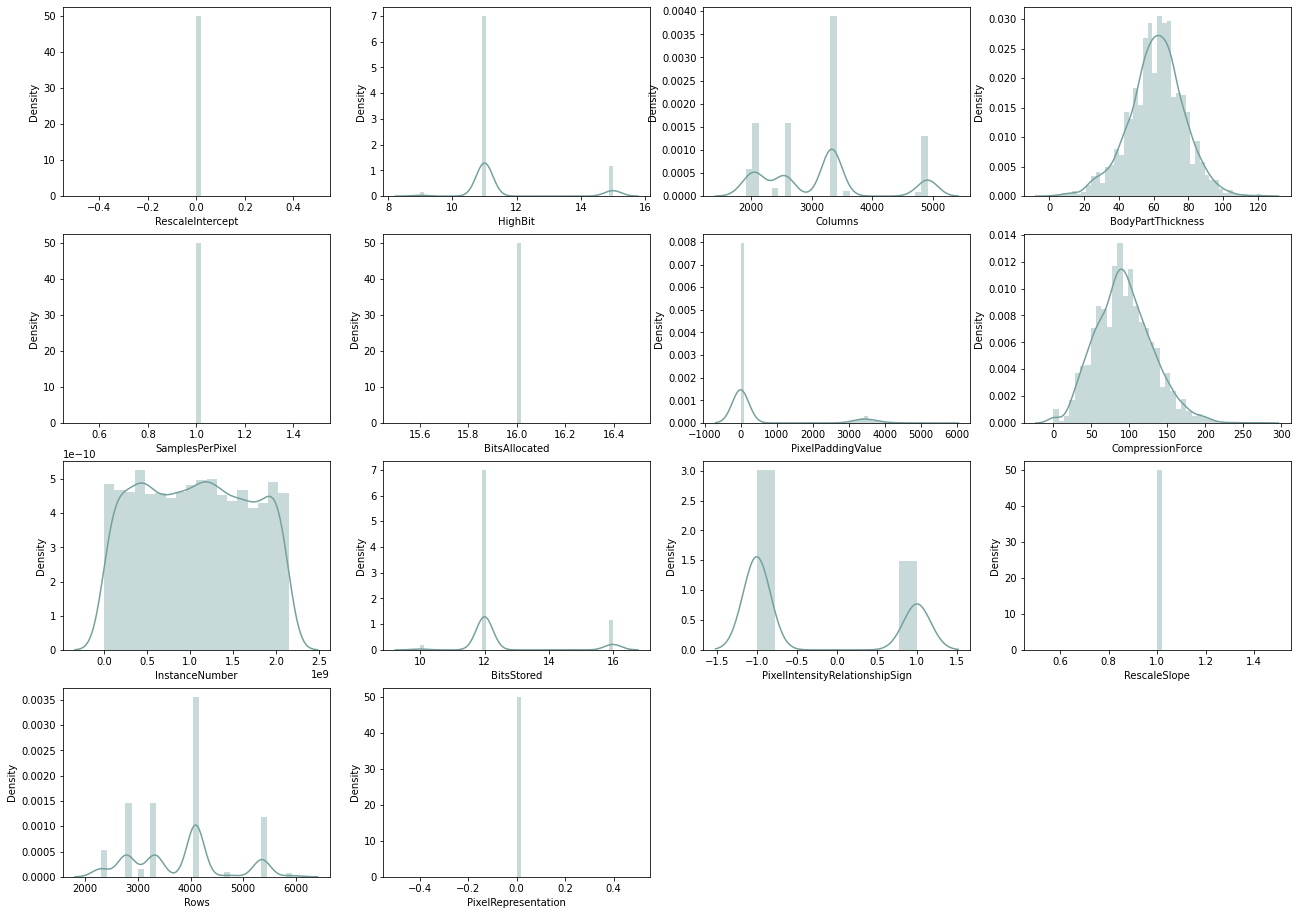

In [8]:
print('Values for Photometric Interpretation: {}'.format(dfmeta['PhotometricInterpretation'].unique()))
print('Values for VOILUTFunction: {}\n'.format(dfmeta['VOILUTFunction'].unique()))

plt.figure(figsize = (22,16))
for i, col in enumerate(dfmeta.select_dtypes([int, float]).columns):
    plt.subplot(4,4, i+1)
    sns.distplot(dfmeta[col], color = custom_colors[0])

📌 **Early Insights**:
* Size of images are big. Rows' peak values are near 4k. For columns this value is 3k. Moreover, we observe that we have images with different sizes and resolutions. Afterwards, we'll determine whether padding is going to be needed. 

In [9]:
dfmeta[['Rows','Columns']].describe().T.style.background_gradient(cmap='GnBu_r')

,count,mean,std,min,25%,50%,75%,max
Rows,5000.000000,3807.662600,892.239926,2294.000000,3062.000000,4096.000000,4096.000000,5928.000000
Columns,5000.000000,3115.035000,911.743177,1914.000000,2394.000000,3328.000000,3328.000000,4915.000000


* `Photometric Interpretation` is set to **MONOCHROME1** and **MONOCHROME2**. We have to be careful about that as image interpretation could vary from one type to the other. The same happens to`VOILUTFunction`, different values are given. 

* The dataset contains **compressed Pixel Data**. By itself pydicom can only handle Pixel Data that hasn't been compressed, but if you install [one or more optional libraries](https://pydicom.github.io/pydicom/stable/tutorials/installation.html#install-the-optional-libraries) then it can handle various compressions. [This table](https://pydicom.github.io/pydicom/stable/old/image_data_handlers.html#supported-transfer-syntaxes) tells you which package is required.

* `BodyPartThickness` refers to the average thickness in mm of the body part examined when compressed, if compression has been applied during exposure.

In [10]:
dfmeta[['CompressionForce','BodyPartThickness']].describe().T.style.background_gradient(cmap='GnBu_r')

,count,mean,std,min,25%,50%,75%,max
CompressionForce,2633.000000,93.372147,37.473086,0.000000,68.057460,90.298460,116.542800,273.119500
BodyPartThickness,2629.000000,61.546596,15.784767,2.000000,52.000000,62.000000,71.000000,122.000000


Let's now show some breast images. 

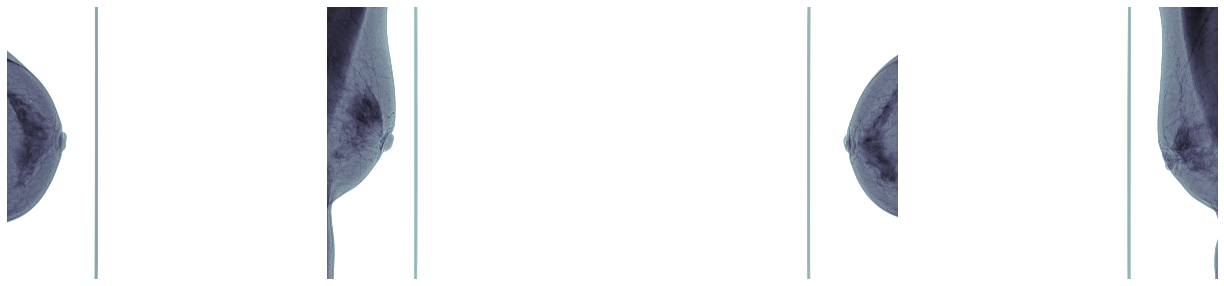

In [11]:
dcm_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/"

def patient_images(p_id): 
    ''' Shows all the images that are associated with the patient for whom the ID is given. '''
    
    figure = plt.figure(figsize = (22,5))
    for i, file in enumerate(listdir(dcm_path + str(p_id) + '/')):
        plt.subplot(1, 4, i+1)
        dataset = pydicom.dcmread(dcm_path + str(p_id) + '/' + file)
        plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
        plt.axis('off');
        
patient_images(train['patient_id'].unique()[0])    

* Breasts are shown in a **small portion** of the image. So it'd be nice to **crop out** those sections of the images that not contain any useful information. As you may have observed, it seems that in some images we're given a vertical line. It could be useful to consider them to do the cropping.

## Site and Patient

Starting with the hospital (site), we can observe that we only have two of them in our dataset. Apart from that, we can observe that **background colors depend on the site** where the image was taken. For site nº 2, background color is blank. However, for site nº 1 this color is almost black

There are 2 different hospitals in the dataset.



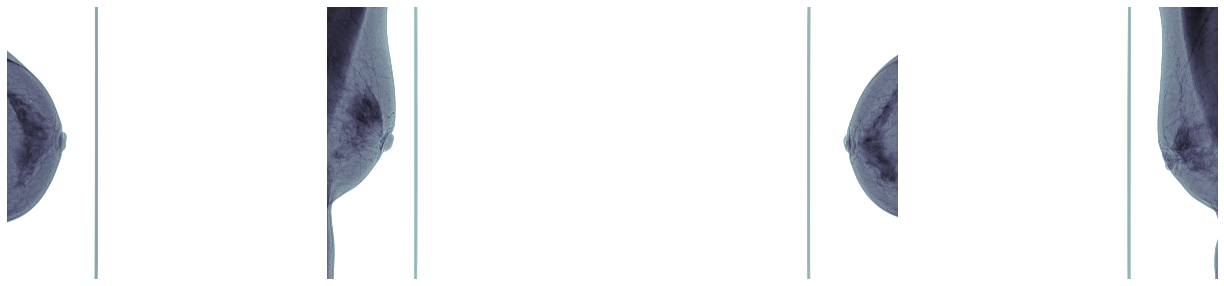

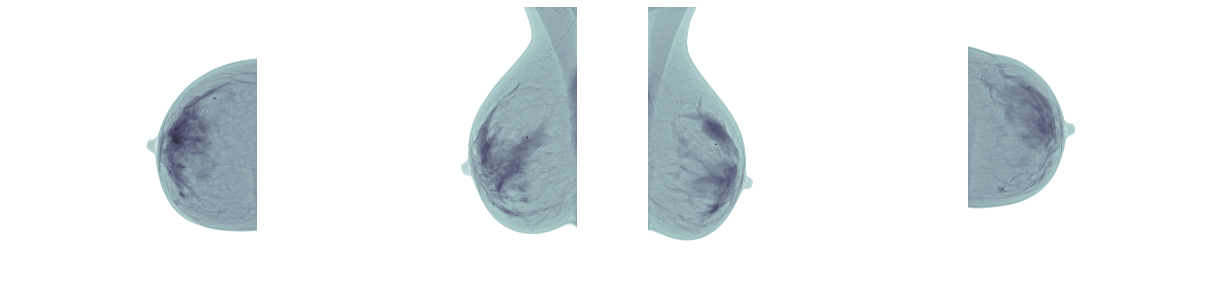

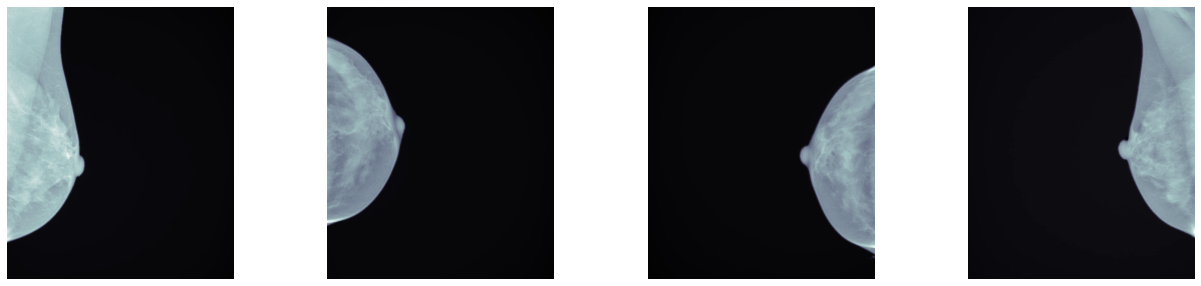

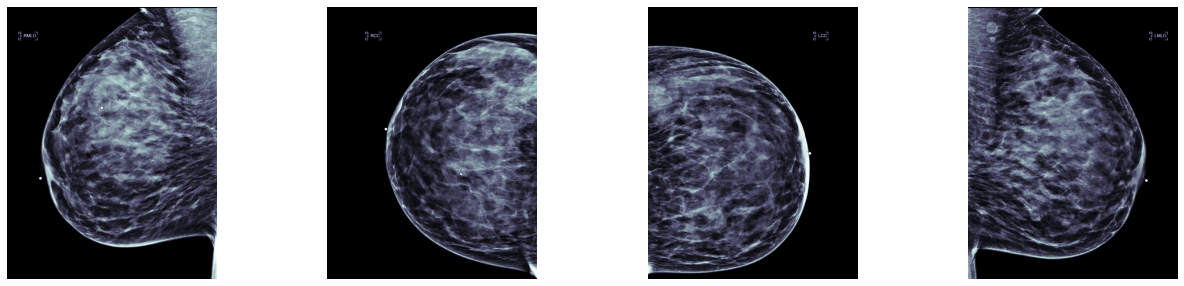

In [12]:
dcm_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/"

def images_site(site_id):
    ids = train[train.site_id == site_id]['patient_id'].unique()
    for i, id_ in enumerate(ids[[0,3]]):
        patient_path = dcm_path + str(id_) +'/'
        fig = plt.figure(figsize = (22,5))
        for j, file in enumerate(listdir(patient_path)):
            plt.subplot(1, 4, j+1)
            dataset = pydicom.dcmread(patient_path + file)
            p = plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
            plt.axis('off');

print('There are {} different hospitals in the dataset.\n'.format(len(train.site_id.unique())))            
for val in train.site_id.unique(): 
    images_site(val)

There are 11913 unique patients in the Train Set.

Minimum number of entries are: 4 
Maximum number of entries are: 14



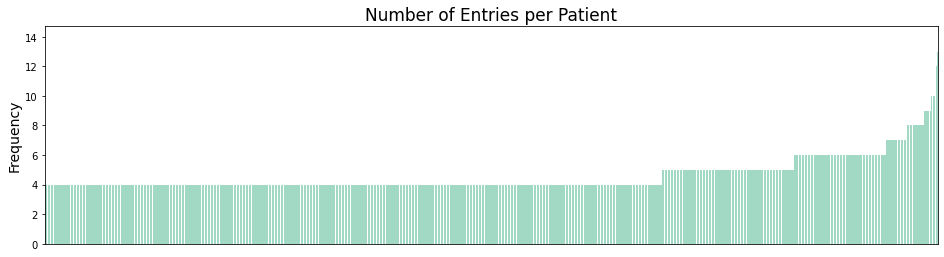

In [13]:
print('There are {} unique patients in the Train Set.'.format(len(train['patient_id'].unique())))

data = train.groupby(by="patient_id")['laterality'].count().reset_index(drop=False)
data = data.sort_values(['laterality']).reset_index(drop=True)

print("\nMinimum number of entries are: {}".format(data["laterality"].min()), "\n" +
      "Maximum number of entries are: {}\n".format(data["laterality"].max()))

plt.figure(figsize = (16, 4))
img = sns.barplot(data.index, data['laterality'], color=custom_colors[2])
plt.title("Number of Entries per Patient", fontsize = 17)
plt.ylabel('Frequency', fontsize=14)
img.axes.get_xaxis().set_visible(False);

* Most common frequency is **4 images per pacient**. However, we observe that there is a big amount of them having between 5-6 of them. Rarely, a pacient has more images asociated. 

## Laterality, View and Age 

* We almost have the same amount of left breast images than right ones. 
* Very few values under 40 years old for `Age`. Some peaks between 50 and 70 yo. 
* Six different values for `view` feature. Quite imbalanced (**CC** and **MLO** are the most common ones). 

`Laterality` feature indicates whether the image is of the left or right breast. This issue can be fixed quite fast with OpenCV tools, for example. We'll focus on it later. `View` instead, refers to the orientation of the image. The default for a screening exam is to capture two views per breast. That's the reason for having almost the same amount of left and right breast images.  

Text(0.5, 1.0, 'Age Dsitribution')

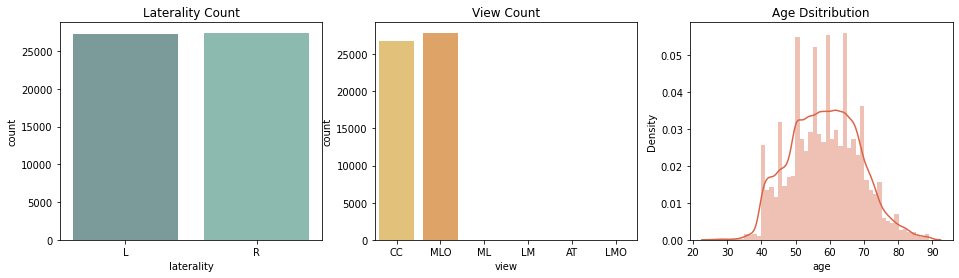

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
sns.countplot(train.laterality, label = ['Left','Right'], ax = axes[0], palette = custom_colors)
axes[0].set_title('Laterality Count')
sns.countplot(train.view, ax = axes[1], palette = custom_colors[3:])
axes[1].set_title('View Count')
sns.distplot(train.age, ax = axes[2], color = custom_colors[5])
axes[2].set_title('Age Dsitribution')

## View

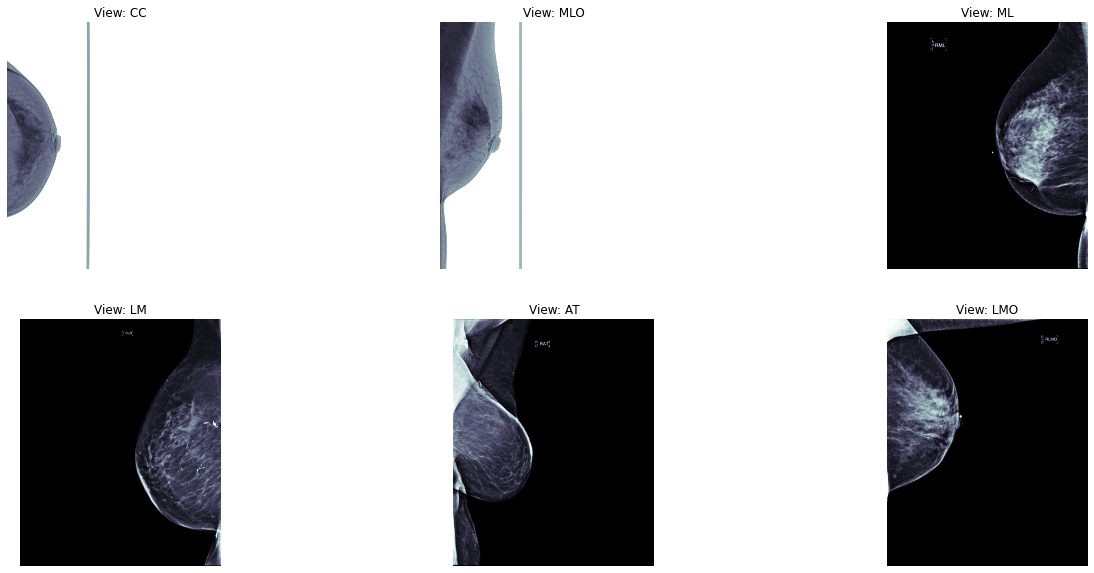

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (22,10))
for i, val in enumerate(train.view.unique()):
    ids = train[train.view == val]['patient_id'].unique()
    image_id = train[(train.patient_id == ids[0]) & (train.view == val)]['image_id']
    img_id = dcm_path + str(ids[0]) + '/' + str(image_id.values[0]) + '.dcm'
    dataset = pydicom.dcmread(img_id)
    axes[i // 3, i % 3].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    axes[i // 3, i % 3].axis('off')
    axes[i // 3, i % 3].set_title('View: {}'.format(val))

Actually **CC and MLO correspond to the main and auxiliary types**, respectively. To find out it by yourselves please head to the following [article](https://radiopaedia.org/articles/craniocaudal-view). Therefore, trying some different approaches when training (such as making a distinction) our models could make a difference and have a ridiculously significant effect in LB. Thus, it's gonna be time-worthy to do some research about it. 

Moreover, let's examine whether there is any relationship between these values and the diagnosis of cancer. Just to remind, except from CC and MLO values the rest have very few samples. We must take this into account to analyse properly these plots. 

> As it can be appreciated, values are the same for CC and MLO types. This makes sense regarding what I told above. 

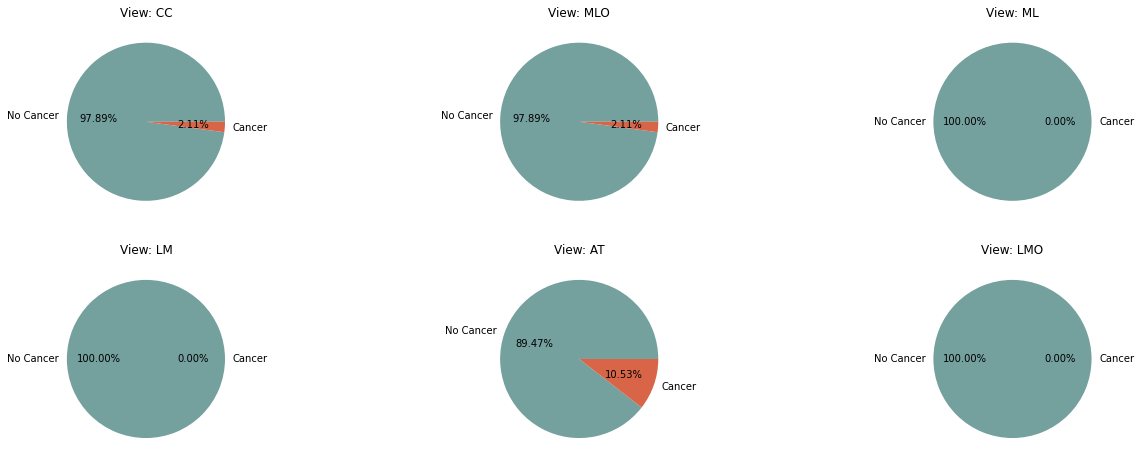

In [16]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (22, 8))
for i, val in enumerate(train.view.unique()):
    dt = [train[(train.view == val) & (train.cancer == c)].shape[0] for c in [0,1]]
    axes[i // 3, i % 3].pie(dt, labels = ['No Cancer','Cancer'], colors=[custom_colors[0], 
                            custom_colors[5]], autopct='%.2f%%')
    axes[i // 3, i % 3].set_title('View: {}'.format(val))

## Cancer, Biopsy, Invasive and BIRADS

* Cancer, biopsy and invasive distributions are very imbalanced. Seems that there could be a relationship between them.
* In `BIRADS` plot, we observe that there are lots of negative ratings for cancer. Rating a breast as normal is the least common one.

Text(0.5, 1.0, 'BIRADS')

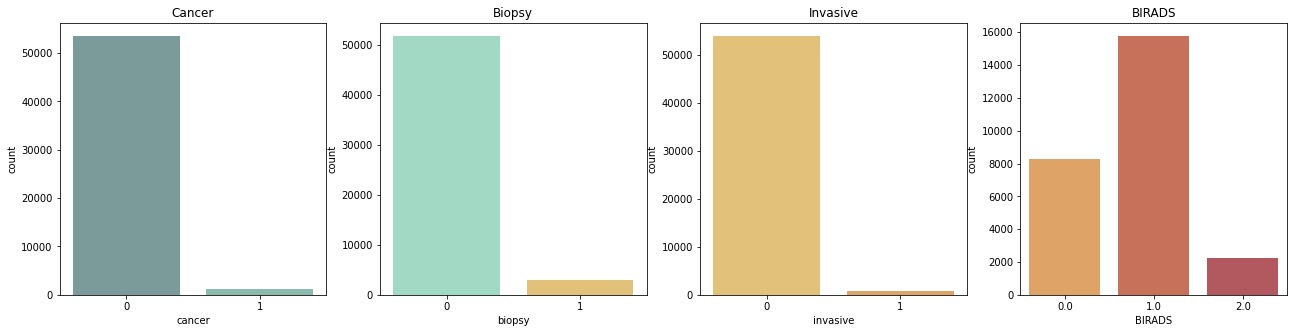

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (22,5))
sns.countplot(train.cancer, ax = axes[0], palette = custom_colors)
axes[0].set_title('Cancer')
sns.countplot(train.biopsy, ax = axes[1], palette = custom_colors[2:])
axes[1].set_title('Biopsy')
sns.countplot(train.invasive, ax = axes[2], palette = custom_colors[3:])
axes[2].set_title('Invasive')
sns.countplot(train.BIRADS, ax = axes[3], palette = custom_colors[4:])
axes[3].set_title('BIRADS')

Any relationship between them ? Let's explore it below. 

* `Invasive` and `cancer` are **very correlated** (this makes sense if we observe features' definitions).   
* Negative correlation between `BIRADS` and the rest of the features. 

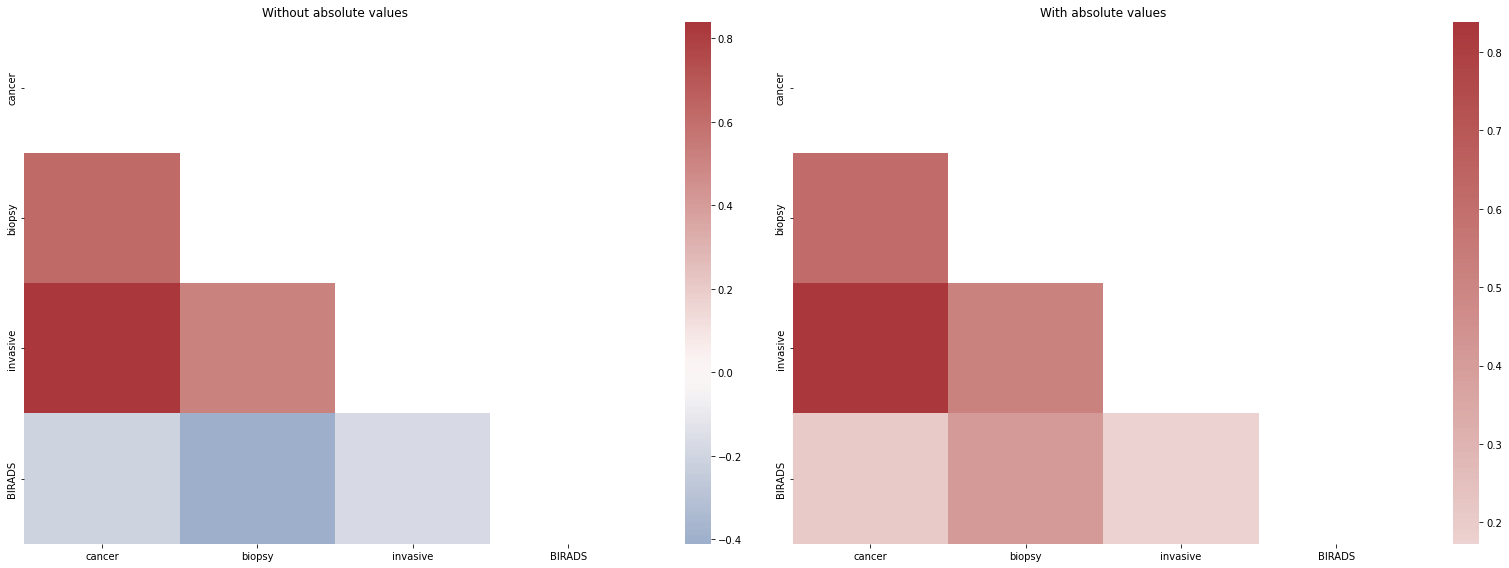

In [18]:
corr= train[['cancer','biopsy','invasive','BIRADS']].corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22,8))
# Heatmap without absolute values
sns.heatmap(corr, mask=matrix, center = 0, cmap = 'vlag', ax = axes[0]).set_title('Without absolute values')
# Heatmap with absolute values
sns.heatmap(abs(corr), mask=matrix, center = 0, cmap = 'vlag', ax = axes[1]).set_title('With absolute values')

fig.tight_layout(h_pad=1.0, w_pad=0.5)

`Biopsy` feature determines whether or not a follow-up biopsy was performed on the breast. Thus, it could be interesting to analyse its relation with `Cancer` and `View` features.

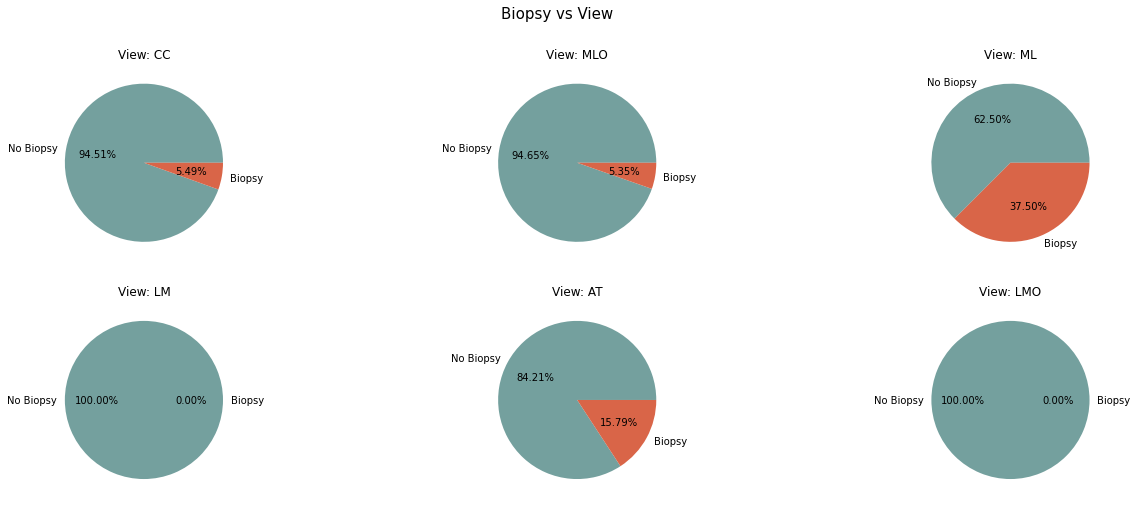

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (22, 8))
fig.suptitle('Biopsy vs View', fontsize = 15)
for i, val in enumerate(train.view.unique()):
    dt = [train[(train.view == val) & (train.biopsy == c)].shape[0] for c in [0,1]]
    axes[i // 3, i % 3].pie(dt, labels = ['No Biopsy','Biopsy'], colors=[custom_colors[0], 
                            custom_colors[5]], autopct='%.2f%%')
    axes[i // 3, i % 3].set_title('View: {}'.format(val))

Now we focus on its relation with cancer diagnosis. It's appreciatable that when there is no need to make a biopsy, cancer diagnosis is discarded. However, we can notice that when it's done we have the same amount of positive and negative results. 

In [20]:
for b in [0,1]: 
    print('Biopsy: {}'.format('Not Performed' if b == 0 else 'Performed'))
    for c in [0,1]: 
        dt = [train[(train.biopsy == b) & (train.cancer == c)].shape[0] for c in [0,1]]
        print('\tPatients with{}diagnosed cancer: {}'.format(' no ' if c == 0 else ' ', dt[c]))

Biopsy: Not Performed
	Patients with no diagnosed cancer: 51737
	Patients with diagnosed cancer: 0
Biopsy: Performed
	Patients with no diagnosed cancer: 1811
	Patients with diagnosed cancer: 1158


## Implant and Density

Let's explore now the other two image features that we're given in this dataset. 

Text(0.5, 1.0, 'Density Count')

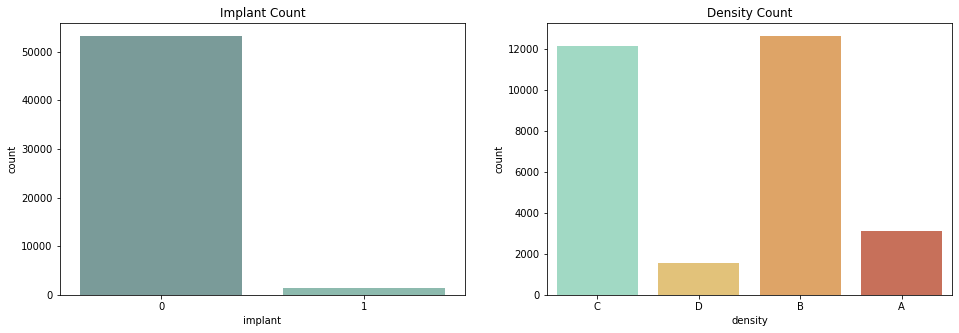

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,5))
sns.countplot(train.implant, label = ['Left','Right'], ax = axes[0], palette = custom_colors)
axes[0].set_title('Implant Count')
sns.countplot(train.density, ax = axes[1], palette = custom_colors[2:])
axes[1].set_title('Density Count')

* Almost every breast have no implants. We have just a few images from breasts with implants. 
* B and C values for `density` are the most usual ones. Just to remind, highly dense tissue can make diagnosis more difficult (case D). So this is something that we'll need to take into account in validation strategies. 

In the following chart we can appreciate the four different types of density that we have. We can notice that the closer the value is to D, we can observe that there are more white spots on the end of the breast. On the other hand, for A density type images, colour is quite uniform.

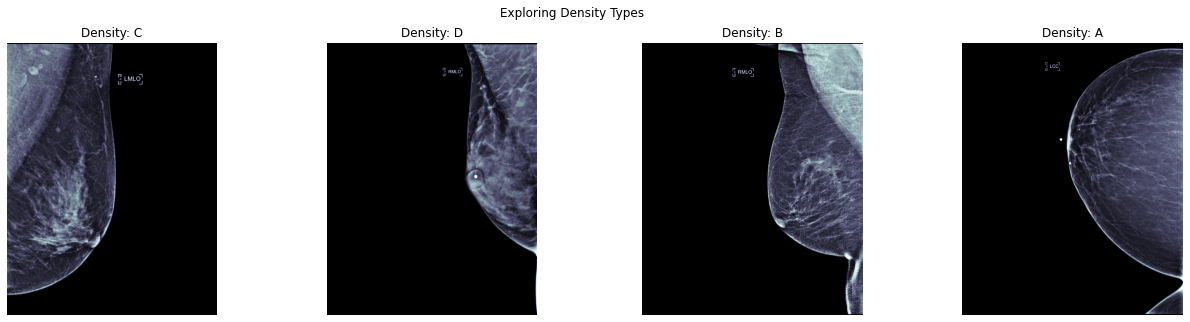

In [22]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (22,5))
fig.suptitle('Exploring Density Types', fontsize = 12)
for i, val in enumerate(train.density.unique()[1:]):
    ids = train[train.density == val]['patient_id'].unique()
    patient_path = dcm_path + str(ids[9]) +'/'
    for j, file in enumerate([listdir(patient_path)[0]]): 
        dataset = pydicom.dcmread(patient_path + file)
        axes[i].imshow(dataset.pixel_array, cmap=plt.cm.bone)
        axes[i].axis('off')
        axes[i].set_title('Density: {}'.format(val))

## Machine ID

This feature does not seem that will have a significant effect. However, we realise that most of the pictures have been taken with machine 49. 

<AxesSubplot:xlabel='machine_id', ylabel='count'>

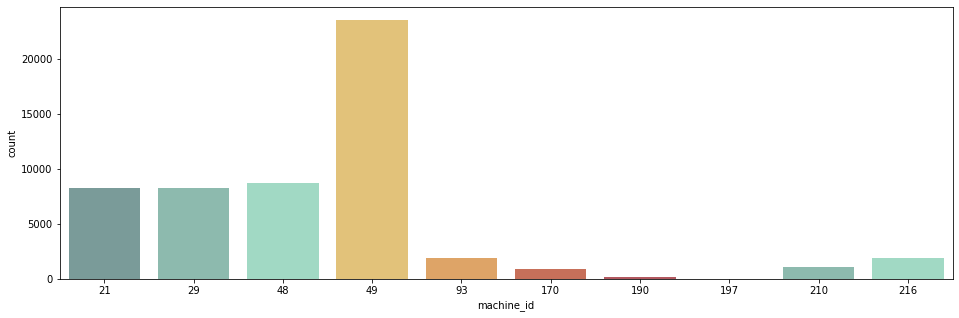

In [23]:
fig = plt.figure(figsize = (16,5))
sns.countplot(train.machine_id, palette = custom_colors)